# BPNN

## Section 1: prediction with 'Close' as target variable.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae, root_mean_squared_error as rmse, r2_score as r2
import yfinance as yf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install xlsxwriter
print(f"Using device: {device}")

Using device: cuda


In [10]:
print("Downloading data...")
df = yf.download("RELIANCE.NS", start='2018-03-01', end='2025-04-30')
df.columns = df.columns.droplevel(1)
df.columns.name = None
df.index.name = 'Date'

print(f"Total samples: {len(df)}")
df.tail()

/tmp/ipython-input-3237112970.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("RELIANCE.NS", start='2018-03-01', end='2025-04-30')
[*********************100%***********************]  1 of 1 completed

Total samples: 1766


,Close,High,Low,Open,Volume
Date,,,,,
2025-04-23,1294.828613,1300.804745,1280.286716,1291.840547,10480888
2025-04-24,1296.422241,1299.310729,1285.167265,1287.258887,10468940
2025-04-25,1295.227051,1319.928324,1282.975931,1298.314695,14431012
2025-04-28,1363.354980,1369.131835,1314.948213,1334.669498,31104496
2025-04-29,1394.131958,1405.287477,1364.550153,1365.546175,32538970


In [11]:
# Create a new dataframe for features shifted by 1 day
features = df[["Open", "High", "Low", "Volume", "Close"]].shift(1) # Yesterday's data
target = df["Close"] # Today's target

# Combine and drop the first row (which will be NaN due to shifting)
data = pd.concat([features, target], axis=1).dropna()

train = data.loc[:'2025-03-31'].copy()
test = data.loc['2025-04-02':].copy()

# Then split X and y
X_train = train.iloc[:, :-1].values # Yesterday's OHLCV
y_train = train.iloc[:, -1].values  # Today's Close
X_test = test.iloc[:, :-1].values # Yesterday's OHLCV
y_test = test.iloc[:, -1].values  # Today's Close

#### single stock

In [12]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)  # Use training scaler

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Features shape: {X_train_scaled.shape}")
print(f"Target shape: {y_train_scaled.shape}")

Features shape: (1747, 5)
Target shape: (1747,)


In [13]:
class BPNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super().__init__()
        layers = []
        prev = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev = h

        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze()

In [14]:
def train_bpnn(X_train, y_train, X_test, epochs=50, lr=1e-3, batch_size=64):
    """
    Train BPNN model
    """
    model = BPNN(input_dim=X_train.shape[1], hidden_dims=[128, 64, 32]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()

    train_ds = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    )
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    train_losses = []

    print("Training BPNN...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")

    # Make predictions
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        preds = model(X_test_tensor).cpu().numpy()

    return preds, train_losses, model

In [15]:
y_pred_scaled, train_losses, model = train_bpnn(
    X_train_scaled, y_train_scaled, X_test_scaled,
    epochs=50, lr=1e-3, batch_size=64
)

# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

Training BPNN...
Epoch 5/50 - Loss: 0.096891
Epoch 10/50 - Loss: 0.072050
Epoch 15/50 - Loss: 0.077813
Epoch 20/50 - Loss: 0.074717
Epoch 25/50 - Loss: 0.064947
Epoch 30/50 - Loss: 0.063040
Epoch 35/50 - Loss: 0.065087
Epoch 40/50 - Loss: 0.072242
Epoch 45/50 - Loss: 0.073108
Epoch 50/50 - Loss: 0.061608


In [37]:
mae_score = mae(y_test, y_pred)
rmse_score = rmse(y_test, y_pred)
r2_score_val = r2(y_test, y_pred)

print("\n" + "="*60)
print("MODEL EVALUATION - APRIL 2025 FORECAST")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae_score:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_score:.2f}")
print(f"R² Score: {r2_score_val:.4f}")
print("="*60)


MODEL EVALUATION - APRIL 2025 FORECAST
Mean Absolute Error (MAE): 19.60
Root Mean Squared Error (RMSE): 27.52
R² Score: 0.8001


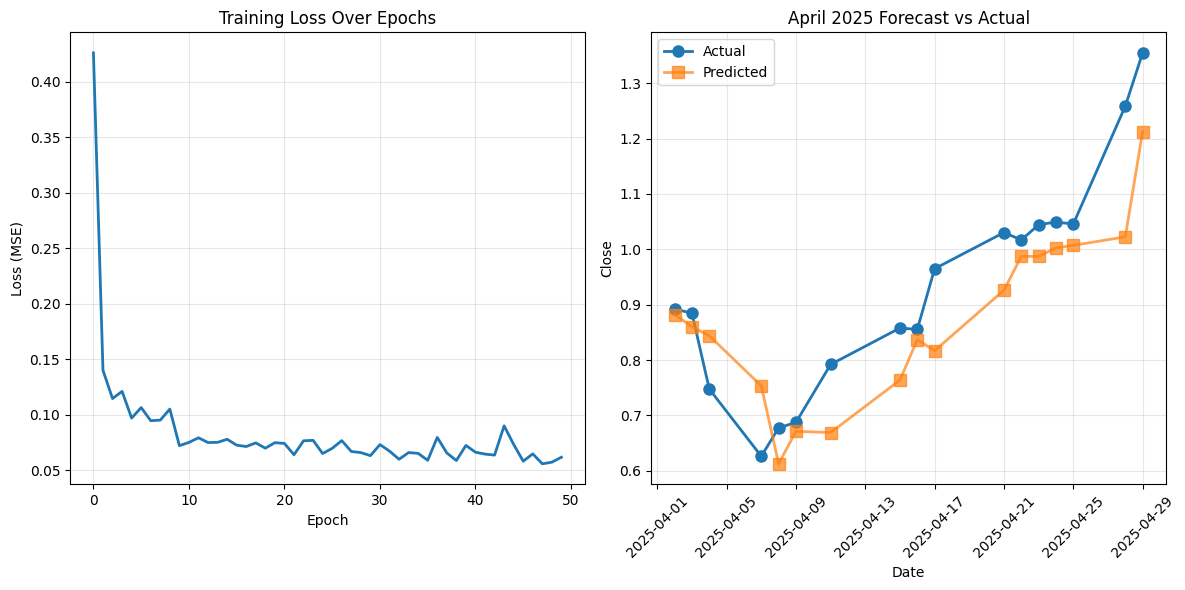

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Plot 1: Training Loss
axes[0].plot(train_losses, linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training Loss Over Epochs')
axes[0].grid(True, alpha=0.3)

# Plot 2: April 2025 Predictions
axes[1].plot(test.index, y_test_scaled, 'o-', label='Actual', linewidth=2, markersize=8)
axes[1].plot(test.index, y_pred_scaled, 's-', label='Predicted', linewidth=2, markersize=8, alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel(f'Close')
axes[1].set_title('April 2025 Forecast vs Actual')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)



plt.tight_layout()
plt.savefig('BPNN_price_pred.png')
plt.show()

In [18]:
y_test_final = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_final = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
error = y_test_final - y_pred_final

print("\n" + "="*60)
print("APRIL 2025 DAILY FORECAST REPORT")
print("="*60)
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual': y_test_final,
    'Predicted': y_pred_final,
    'Error': error,
    'Error_%': (error / y_test_final) * 100
})
forecast_df


APRIL 2025 DAILY FORECAST REPORT


,Date,Actual,Predicted,Error,Error_%
0,2025-04-02,1246.172974,1242.927856,3.245117,0.260407
1,2025-04-03,1243.732666,1235.931885,7.800781,0.627207
2,2025-04-04,1199.907593,1230.703369,-30.795776,-2.566512
3,2025-04-07,1161.062744,1201.759399,-40.696655,-3.505121
4,2025-04-08,1177.497192,1156.716064,20.781128,1.764856
5,2025-04-09,1180.634644,1175.494629,5.140015,0.435360
6,2025-04-11,1214.100952,1174.765625,39.335327,3.239873
7,2025-04-15,1235.166870,1205.096680,30.070190,2.434504
8,2025-04-16,1234.370117,1228.422974,5.947144,0.481796
9,2025-04-17,1269.430054,1222.050903,47.379150,3.732317


#### 25 stocks

In [19]:
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import pandas as pd
import numpy as np

class PerStockBPNNExperiment:
    def __init__(self, tickers, start, end, split_date):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.split_date = pd.Timestamp(split_date)

    def load_data(self, ticker):
        df = yf.download(
            ticker,
            start=self.start,
            end=self.end,
            auto_adjust=True,
            progress=False
        )
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
        df.columns.name = None
        df.index.name = "Date"
        return df[["Open", "High", "Low", "Close", "Volume"]].dropna()

    def split(self, df):
        train = df[df.index < self.split_date]
        test  = df[df.index >= self.split_date]
        return train, test

    def run(self):
        rows = []
        for ticker in self.tickers:
            df = self.load_data(ticker)

            # 1. CREATE SHIFTED FEATURES GLOBALLY
            #    We explicitly name them to avoid confusion
            features = df[["Open", "High", "Low", "Volume"]].shift(1)
            target = df["Close"]

            # 2. COMBINE & CLEAN
            #    This aligns X(t-1) with y(t) and drops the first NaN row
            data = pd.concat([features, target], axis=1).dropna()

            # 3. SPLIT THE CLEAN DATA
            train = data[data.index < self.split_date]
            test  = data[data.index >= self.split_date]

            if len(train) == 0 or len(test) == 0:
                continue

            # 4. ASSIGN X AND y
            X_train = train.iloc[:, :-1].values
            y_train = train.iloc[:, -1].values

            X_test  = test.iloc[:, :-1].values
            y_test  = test.iloc[:, -1].values

            # -------- scaling (train only) --------
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

            X_train = scaler_X.fit_transform(X_train)
            X_test  = scaler_X.transform(X_test)

            y_train_scaled = scaler_y.fit_transform(
                y_train.reshape(-1,1)
            ).ravel()

            # -------- train + predict --------
            y_pred_scaled = train_bpnn(
                X_train, y_train_scaled, X_test
            )[0] # Extract only the predictions

            # inverse-transform predictions
            y_pred = scaler_y.inverse_transform(
                y_pred_scaled.reshape(-1,1)
            ).ravel()

            # -------- metrics --------
            rows.append({
                "Ticker": ticker,
                "MAE":  mae(y_test, y_pred),
                "RMSE": rmse(y_test, y_pred),
                "R2":   r2(y_test, y_pred)
            })

        return pd.DataFrame(rows)


In [20]:
!pip install xlsxwriter

tickers = [
    "RELIANCE.NS",     # Large-cap
    "TCS.NS",          # Large-cap
    "HDFCBANK.NS",     # Large-cap
    "PIDILITIND.NS",   # Mid-cap
    "AUBANK.NS",       # Mid-cap
    "IEX.NS",          # Small-cap
    "MAPMYINDIA.NS",   # Small-cap
    "LTTS.NS",          # Small-cap / mid-tech
    "AAPL",     # Large-cap
    "MSFT",     # Large-cap
    "GOOGL",    # Large-cap
    "AMZN",     # Large-cap
    "NVDA",     # Large-cap
    "CRWD",     # Mid-cap
    "PLTR",     # Mid-cap
    "FSLR",     # Mid-cap
    "CELH",     # Small-cap
    "U",         # Small-cap / mid-tech
    "HSBA.L",   # Large-cap
    "BP.L",     # Large-cap
    "ULVR.L",   # Large-cap
    "AUTO.L",   # Mid-cap
    "JDW.L",    # Mid-cap
    "CER.L",    # Small-cap
]
exp = PerStockBPNNExperiment(
    tickers=tickers,
    start="2018-03-01",
    end="2025-04-30",
    split_date="2025-04-01"
)

df_bpnn = exp.run()
styled_df = df_bpnn.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#f7f7f7')]},
    {'selector': 'td', 'props': [('text-align', 'center')]} # Optional: centers the data values too
])

styled_df.to_excel("BPNN_metrics_price.xlsx", engine='xlsxwriter')
styled_df

Training BPNN...
Epoch 5/50 - Loss: 0.106279
Epoch 10/50 - Loss: 0.077158
Epoch 15/50 - Loss: 0.077617
Epoch 20/50 - Loss: 0.076977
Epoch 25/50 - Loss: 0.070297
Epoch 30/50 - Loss: 0.065653
Epoch 35/50 - Loss: 0.070373
Epoch 40/50 - Loss: 0.070429
Epoch 45/50 - Loss: 0.062822
Epoch 50/50 - Loss: 0.060972
Training BPNN...
Epoch 5/50 - Loss: 0.104622
Epoch 10/50 - Loss: 0.086091
Epoch 15/50 - Loss: 0.071522
Epoch 20/50 - Loss: 0.062056
Epoch 25/50 - Loss: 0.067535
Epoch 30/50 - Loss: 0.075173
Epoch 35/50 - Loss: 0.064584
Epoch 40/50 - Loss: 0.057394
Epoch 45/50 - Loss: 0.059592
Epoch 50/50 - Loss: 0.062187
Training BPNN...
Epoch 5/50 - Loss: 0.087033
Epoch 10/50 - Loss: 0.088046
Epoch 15/50 - Loss: 0.067526
Epoch 20/50 - Loss: 0.076389
Epoch 25/50 - Loss: 0.058740
Epoch 30/50 - Loss: 0.067488
Epoch 35/50 - Loss: 0.067929
Epoch 40/50 - Loss: 0.066261
Epoch 45/50 - Loss: 0.069515
Epoch 50/50 - Loss: 0.068195
Training BPNN...
Epoch 5/50 - Loss: 0.097411
Epoch 10/50 - Loss: 0.076553
Epoch 15

,Ticker,MAE,RMSE,R2
0,RELIANCE.NS,40.288079,46.612223,0.393661
1,TCS.NS,64.894491,74.315837,0.417373
2,HDFCBANK.NS,36.865865,39.983037,-0.441400
3,PIDILITIND.NS,71.303833,73.337725,-2.489605
4,AUBANK.NS,22.992737,31.648333,0.698024
5,IEX.NS,7.648667,8.210775,-0.589347
6,MAPMYINDIA.NS,24.684787,30.738265,0.493931
7,LTTS.NS,101.845825,120.045234,0.438609
8,AAPL,7.806911,9.046838,0.441795
9,MSFT,12.725977,15.312254,-0.520743


Even for a single stock and only ~1.7k samples, BPNN gave an R2 score of ~0.95. That's as good as Linear Regression. However, usually for an NN to work well and better than ML models, large amount of data is required. But such great score even for small data tells the potential of BPNN. Now, BPNN should be redesigned in a way a NN should be.

## Section 2: Using log-returns

### Single stock

In [21]:
# writing BPNN for log-return target
class BPNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()


In [29]:
class LogReturnBPNNExperiment:
    def __init__(
        self,
        ticker,
        start,
        end,
        split_date,
        epochs=50,
        batch_size=256,
        lr=1e-3
    ):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.split_date = pd.Timestamp(split_date)
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def load_data(self):
        df = yf.download(
            self.ticker,
            start=self.start,
            end=self.end,
            auto_adjust=True,
            progress=False
        )
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        df.columns.name = None
        df.index.name = "Date"

        df["log_ret"] = np.log(df["Close"]).diff()

        feature_cols = ["Open", "High", "Low", "Volume"]
        for col in feature_cols:
            df[f"{col}_lag1"] = df[col].shift(1)

        df = df.dropna()
        return df

    def run(self):
        df = self.load_data()
        features = ["Open_lag1", "High_lag1", "Low_lag1", "Volume_lag1"]

        train = df[df.index < self.split_date]
        test  = df[df.index >= self.split_date]

        X_train = train[features].values
        y_train = train["log_ret"].values
        X_test  = test[features].values
        y_test  = test["log_ret"].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train = scaler_X.fit_transform(X_train)
        X_test  = scaler_X.transform(X_test)
        y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        train_ds = TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.float32)
        )
        train_loader = DataLoader(
            train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=torch.cuda.is_available()
        )

        model = BPNN(input_dim=X_train.shape[1]).to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=1e-4)
        loss_fn = nn.MSELoss()

        model.train()
        train_losses = []
        for epoch in range(self.epochs):
            total_loss = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                pred = model(xb).view(-1)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            train_losses.append(avg_loss)

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{self.epochs} - Loss: {total_loss/len(train_loader):.6f}")

        model.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test, dtype=torch.float32).to(self.device)
            y_pred_scaled = model(X_test_t).cpu().numpy()

        y_pred_logret = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # align prices with predicted log-returns
        prev_price = test["Close"].values[:-1]
        price_pred = prev_price * np.exp(y_pred_logret[1:])
        y_true_price = test["Close"].values[:-1]


        return y_true_price, price_pred, y_pred_logret, y_test

In [30]:
exp = LogReturnBPNNExperiment(
    ticker="RELIANCE.NS",
    start="2018-03-01",
    end="2025-04-30",
    split_date="2025-04-01",
    epochs=100
)

y_true, y_pred, y_pred_logret, y_true_logret = exp.run()


Epoch 5/100 - Loss: 0.990119
Epoch 10/100 - Loss: 0.992388
Epoch 15/100 - Loss: 0.999572
Epoch 20/100 - Loss: 0.989789
Epoch 25/100 - Loss: 0.999382
Epoch 30/100 - Loss: 0.995958
Epoch 35/100 - Loss: 1.001564
Epoch 40/100 - Loss: 1.002845
Epoch 45/100 - Loss: 0.989583
Epoch 50/100 - Loss: 0.991564
Epoch 55/100 - Loss: 0.989175
Epoch 60/100 - Loss: 0.993352
Epoch 65/100 - Loss: 0.992597
Epoch 70/100 - Loss: 0.993603
Epoch 75/100 - Loss: 0.982746
Epoch 80/100 - Loss: 0.986710
Epoch 85/100 - Loss: 0.985681
Epoch 90/100 - Loss: 0.995219
Epoch 95/100 - Loss: 0.984971
Epoch 100/100 - Loss: 0.982623


In [31]:
print("Downloading data...")
df = yf.download("RELIANCE.NS", start='2018-03-01', end='2025-04-30')
df.columns = df.columns.droplevel(1)
df.columns.name = None
df.index.name = 'Date'

print(f"Total samples: {len(df)}")
train = df.loc[:'2025-03-31'].copy()
test = df.loc['2025-04-02':].copy()


/tmp/ipython-input-2910652749.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("RELIANCE.NS", start='2018-03-01', end='2025-04-30')
[*********************100%***********************]  1 of 1 completed

Total samples: 1766


In [32]:
mae_score = mae(y_true, y_pred)
rmse_score = rmse(y_true, y_pred)
r2_score_val = r2(y_true, y_pred)

print("\n" + "="*60)
print("MODEL EVALUATION - APRIL 2025 FORECAST")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae_score:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_score:.2f}")
print(f"R² Score: {r2_score_val:.4f}")
print("="*60)


MODEL EVALUATION - APRIL 2025 FORECAST
Mean Absolute Error (MAE): 1.08
Root Mean Squared Error (RMSE): 1.28
R² Score: 0.9994


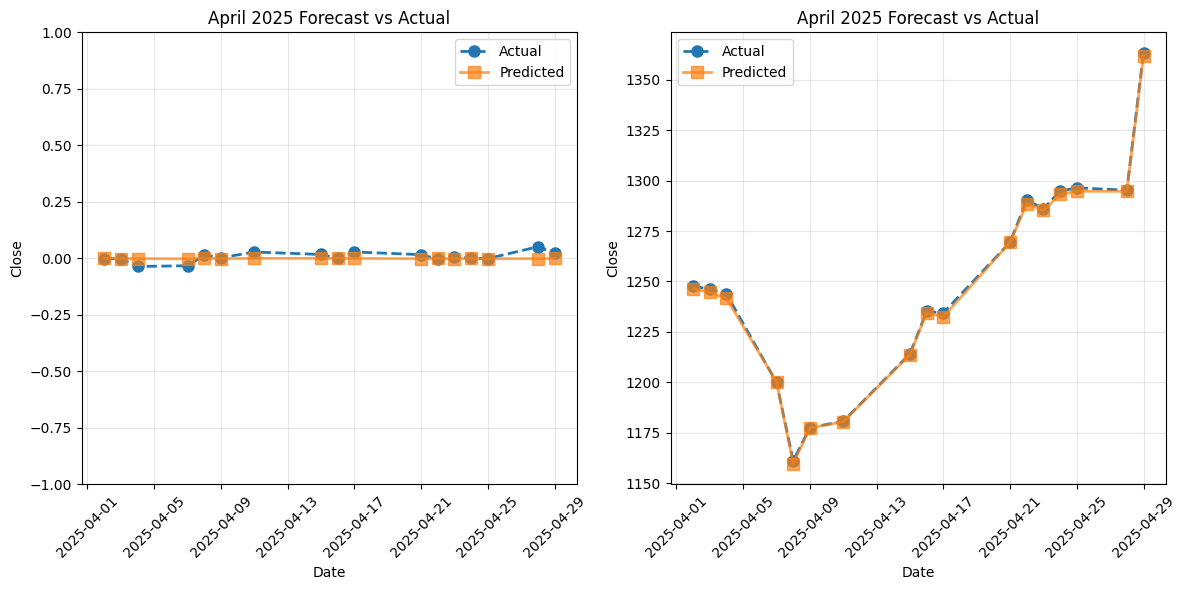

In [33]:
true_logret = y_true_logret[1:]
pred_logret = y_pred_logret[:-1]
dates = test.index[1:]


fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Plot 1: true log-return vs predicted log-return
axes[0].plot(test.index, true_logret, 'o--', label='Actual', linewidth=2, markersize=8)
axes[0].plot(test.index, pred_logret, 's-', label='Predicted', linewidth=2, markersize=8, alpha=0.7)
axes[0].set_ylim(-1,1)
axes[0].set_xlabel('Date')
axes[0].set_ylabel(f'Close')
axes[0].set_title('April 2025 Forecast vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: April 2025 Predictions
axes[1].plot(test.index, y_true, 'o--', label='Actual', linewidth=2, markersize=8)
axes[1].plot(test.index, y_pred, 's-', label='Predicted', linewidth=2, markersize=8, alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel(f'Close')
axes[1].set_title('April 2025 Forecast vs Actual')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)



plt.tight_layout()
plt.savefig("BPNN_logret_pred.png")
plt.show()

### 25 stocks

In [34]:
class MultiStockLogReturnBPNN:
    def __init__(self, tickers, start, end, split_date, **model_kwargs):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.split_date = split_date
        self.model_kwargs = model_kwargs

    def run(self):
        rows = []

        for ticker in self.tickers:
            try:
                exp = LogReturnBPNNExperiment(
                    ticker=ticker,
                    start=self.start,
                    end=self.end,
                    split_date=self.split_date,
                    **self.model_kwargs
                )

                y_true, y_pred, _, _ = exp.run()

                rows.append({
                    "Ticker": ticker,
                    "MAE":  mae(y_true, y_pred),
                    "RMSE": rmse(y_true, y_pred),
                    "R2":   r2(y_true, y_pred)
                })

                print(f"{ticker} done")

            except Exception as e:
                print(f"{ticker} failed: {e}")

        return pd.DataFrame(rows)


In [35]:
tickers = [
    "RELIANCE.NS",     # Large-cap
    "TCS.NS",          # Large-cap
    "HDFCBANK.NS",     # Large-cap
    "PIDILITIND.NS",   # Mid-cap
    "AUBANK.NS",       # Mid-cap
    "IEX.NS",          # Small-cap
    "MAPMYINDIA.NS",   # Small-cap
    "LTTS.NS",          # Small-cap / mid-tech
    "AAPL",     # Large-cap
    "MSFT",     # Large-cap
    "GOOGL",    # Large-cap
    "AMZN",     # Large-cap
    "NVDA",     # Large-cap
    "CRWD",     # Mid-cap
    "PLTR",     # Mid-cap
    "FSLR",     # Mid-cap
    "CELH",     # Small-cap
    "U",         # Small-cap / mid-tech
    "HSBA.L",   # Large-cap
    "BP.L",     # Large-cap
    "ULVR.L",   # Large-cap
    "AUTO.L",   # Mid-cap
    "JDW.L",    # Mid-cap
    "CER.L",    # Small-cap
]

runner = MultiStockLogReturnBPNN(
    tickers=tickers,
    start="2018-03-01",
    end="2025-04-30",
    split_date="2025-04-01",
    epochs=50,
    batch_size=256,
    lr=1e-3
)

results_df = runner.run()

styled_df = results_df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#f7f7f7')]},
    {'selector': 'td', 'props': [('text-align', 'center')]} # Optional: centers the data values too
])

styled_df.to_excel("BPNN_Metrics_logret.xlsx", engine='xlsxwriter')
styled_df

Epoch 5/50 - Loss: 0.996584
Epoch 10/50 - Loss: 1.000311
Epoch 15/50 - Loss: 1.008342
Epoch 20/50 - Loss: 0.991138
Epoch 25/50 - Loss: 0.994480
Epoch 30/50 - Loss: 0.995606
Epoch 35/50 - Loss: 0.993143
Epoch 40/50 - Loss: 0.991789
Epoch 45/50 - Loss: 0.993736
Epoch 50/50 - Loss: 0.990000
RELIANCE.NS done
Epoch 5/50 - Loss: 0.997037
Epoch 10/50 - Loss: 0.993325
Epoch 15/50 - Loss: 0.984249
Epoch 20/50 - Loss: 0.993715
Epoch 25/50 - Loss: 0.988111
Epoch 30/50 - Loss: 0.986802
Epoch 35/50 - Loss: 0.984571
Epoch 40/50 - Loss: 0.990263
Epoch 45/50 - Loss: 0.983635
Epoch 50/50 - Loss: 0.978889
TCS.NS done
Epoch 5/50 - Loss: 1.000653
Epoch 10/50 - Loss: 0.988335
Epoch 15/50 - Loss: 0.993083
Epoch 20/50 - Loss: 0.997496
Epoch 25/50 - Loss: 0.993246
Epoch 30/50 - Loss: 0.987413
Epoch 35/50 - Loss: 0.983756
Epoch 40/50 - Loss: 0.988378
Epoch 45/50 - Loss: 0.989007
Epoch 50/50 - Loss: 0.985224
HDFCBANK.NS done
Epoch 5/50 - Loss: 0.994070
Epoch 10/50 - Loss: 0.984989
Epoch 15/50 - Loss: 0.989171
E

,Ticker,MAE,RMSE,R2
0,RELIANCE.NS,0.532927,0.673733,0.999827
1,TCS.NS,4.294811,5.618647,0.996595
2,HDFCBANK.NS,1.227135,1.437651,0.998172
3,PIDILITIND.NS,1.804971,1.962138,0.997608
4,AUBANK.NS,1.461976,1.736472,0.998923
5,IEX.NS,0.475798,0.521111,0.993323
6,MAPMYINDIA.NS,1.843093,1.927495,0.997823
7,LTTS.NS,12.190414,13.117020,0.993461
8,AAPL,0.149250,0.169081,0.999807
9,MSFT,0.672412,0.721671,0.996459
